### Performance

성과 통계량은 리스크를 조정하지 않은 Net Performance (NAV, Net Asset Value)와 수익률 수치다. 몇몇 유용한 성과 척도는 다음과 같다.

- 손익 : 백테스트 전체에 발생한 금액의 총액으로서 최종 포지션의 현금화 비용을 포함한다.
- 롱 포지션으로부터의 손익 : 손익 금액 중 오직 롱 포지션으로만 발생한 비중이다. 이 값은 Long-short 편향과 시장 중립 전략을 평가할 때 매우 유용하다.
- 수익률 연환산 비율 : 총 수익률의 시간 가중 연환산 평균 비율로, 배당, 쿠폰, 비용을 포함한다.
- Hit Ratio : 양의 수익 결과를 낸 배팅의 비중. 즉 관측치 중에서 양의값을 전체 관측치의 개수로 나눈것이다.
- Return rate from hit : 수익을 낸 베팅의 평균 수익률
- Return rate from miss : 손실을 낸 베팅의 평균 수익률

#### 1. Time Weighted rate of returns

총 수익률이란 측정 기간의 경과 이자, 지급 쿠폰, 배당을 포함한 실현과 비실현 손실로부터의 수익률이다. GIPS규칙은 외부 현금 흐름을 조정한 시간 가중 수이률을 계산한다. 기간 또는 하위 기간의 수익률은 기하학적으로 연계되어 있다. 2005년 1월 1일 이후에 시작하는 기간에 대해 GIPS 규정은 일별 가중 외부 현금 흐름으로 조정된 포트폴리오 수익률을 계산하도록 요구한다.

### Efficiency

지금까지의 모든 성과 통계량은 이익, 손실, 비용을 고려했다. 이번 절에서는 이런 결과를 성취하는 데 관련된 리스크를 고려해 본다.

#### 1. Sharpe Ratio

전략의 초과 수익률(무위험이자율 대비) $\{r_t\}_{t = 1, \dots, T}$가 평균이 $\mu$이고 분산이 $\sigma^2$인 IID 가우시안 분포라고 가정해 보자. Sharpe Ratio는 다음과 같이 정의된다.

$$\text{SR} = \frac{\mu}{\sigma}$$

$\text{SR}$의 목적은 특정 전략이나 투자가의 기술을 평가하기 위한 것이다. 대개 $\mu, \sigma$는 알 수 없기 때문에 참 $\text{SR}$값은 확실히 알 수 없다. 이는 불가피하게 결과적으로 $\text{SR}$ 계산은 근본적인 추정 오차를 갖게 한다.

#### 2. Probabilistic Sharpe Ratio

PSR은 한쪽으로 치우치고, fat tail을 가진 수익률로부터 발생하는 과대 평가 효과를 제거해 수정된 $\text{SR}$ 추정값을 제공한다. 주어진 사용자 정의 벤치마크 sharpe ratio와 관측된 Sharpe Ratio가 주어졌을 때, PSR은 $\hat{\text{SR}}$이 가상의 $\text{SR}^*$보다 클 확률을 추정한다. Bailey, Lopez de Prado(2012)의 논문에 따르면 PSR은 다음과 같이 추정할 수 있다.

$$\hat{\text{PSR}}\left[ \text{SR}^*\right] = Z\left[ \frac{\left( \hat{\text{SR}} - \text{SR}^* \sqrt{T-1}\right)}{
\sqrt{1 - \hat{\gamma}_3 \hat{\text{SR}} + \frac{\hat{\gamma}_4 - 1}{4}\hat{\text{SR}}^2}
}\right]$$

여기서 $Z[\cdot]$는 표준 정규 분포의 누적정규분포이고, $T$는 관측된 수익률의 개수, $\hat{\gamma}_3$은 수익률의 왜도, $\hat{\gamma}_4$는 수익률의 첨도를 의미한다. 주어진 $\text{SR}^*$에 대해서 $\text{PSR}$은 $\hat{\text{SR}}$이 더 크거나 트랙 레코드가 더 길고, 양의 왜도를 가진 수익률일수록 증가하지만 첨도가 높을 경우에는 감소한다. 아래의 코드는 $\hat{\gamma}_4, \hat{\text{SR}} = 1.5, \text{SR}^* = 1.0$에 대해 $\hat{\text{PSR}}$을 $\hat{\gamma}_3$과 $T$의 함수로 나타낸 것이다.

In [1]:
import numpy as np
import pandas as pd
from FinancialMachineLearning.backtest.backtest_statistics import probabilistic_sharpe_ratio
from tqdm import tqdm

KURT = 3.0
SR_hat = 1.5
target_SR = 1.0

psr = pd.DataFrame(
    dtype = float,
    index = range(1, 51),
    columns = np.round(np.arange(-1.5, 1, 0.01), 2)
)

for SKEW in tqdm(np.round(np.arange(-1.5, 1, 0.01), 2)) :
    for T in range(1, 51) :
        psr.loc[T, SKEW] = probabilistic_sharpe_ratio(
            observed_sr = SR_hat,
            benchmark_sr = target_SR,
            number_of_returns = T,
            skewness_of_returns = SKEW,
            kurtosis_of_returns = KURT
        )
        
psr.sort_index(ascending = False, inplace = True)

100%|██████████| 250/250 [00:00<00:00, 430.46it/s]


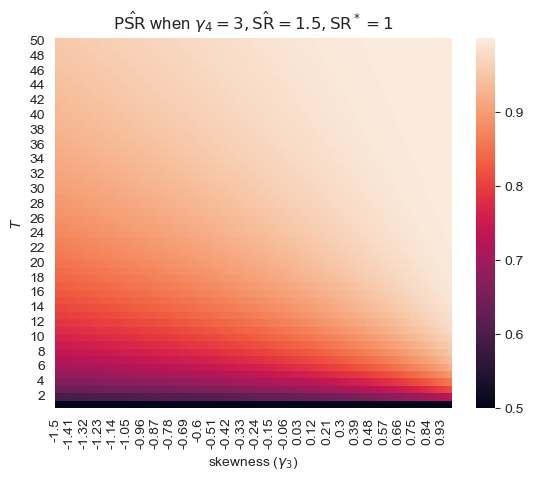

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(psr)
plt.xlabel(r'skewness ($\gamma_3$)')
plt.ylabel(r'$T$')
plt.title(r'$\hat{\text{PSR}}$ when $\gamma_4 = 3, \hat{\text{SR}} = 1.5, \text{SR}^* = 1$')
plt.show()

#### Deflated Sharpe Ratio

DSR은 기각 임계값(criterion)이 반복 시행 횟수를 반영해 조정된 $\text{PSR}$이다. Bailey와 Lopez de Prado(2014)의 논문에 따르면 $\text{DSR}$은 $\hat{\text{PSR}[\text{SR}^*]}$로 추정할 수 있다. 여기서 벤치마크 sharpe ratio $\hat{\text{SR}^*}$은 더이상 사용자 정의 함수가 아니다. 그 대신, $\text{SR}^*$은 다음과 같이 추정된다.

$$\text{SR}^* = \sqrt{V\left[ \left\{ \hat{\text{SR}_n}\right\}\right]} = \left( (1 - \gamma)Z^{-1} \left[ 1 - \frac{1}{N}\right] + \gamma Z^{-1}\left[ 1 - \frac{1}{N}e^{-1}\right]\right)$$

여기서 $V\left[ \left\{ \hat{\text{SR}_n}\right\}\right]$은 반복 시행으로 추정된 샤프 비율에 대한 분산, $N$은 반복 시행 수, $Z$는 표준 정규 분포의 누적분포, $\gamma$는 오일러-마스케로니 상수이며, $n = 1, \dots, N$이다. 아래의 코드는 $\text{SR}$을 $V\left[ \left\{ \hat{\text{SR}_n}\right\}\right]$과 $N$의 함수로 나타낸 것이다.

In [9]:
import scipy.stats as ss

variance = np.round(np.arange(0.1, 1.01, 0.01), 2)
nObs = range(2, 51)
KURT = 3
SKEW = 0
observed_sr = 1

dsr = pd.DataFrame(
    dtype = float,
    index = range(2, 31),
    columns = np.round(np.arange(0.1, 1.01, 0.01), 2)
)

for N in nObs :
    for V in variance :
        benchmark_sr = np.sqrt(V) * ((1 - np.euler_gamma) * ss.norm.ppf(1 - (1 / N)) + np.euler_gamma * ss.norm.ppf(1 - (1 / N) * np.e ** (-1)))
        deflated_sr = probabilistic_sharpe_ratio(observed_sr, benchmark_sr, 5, SKEW, KURT)
        dsr.loc[N, V] = deflated_sr

dsr.sort_index(ascending = False, inplace = True)

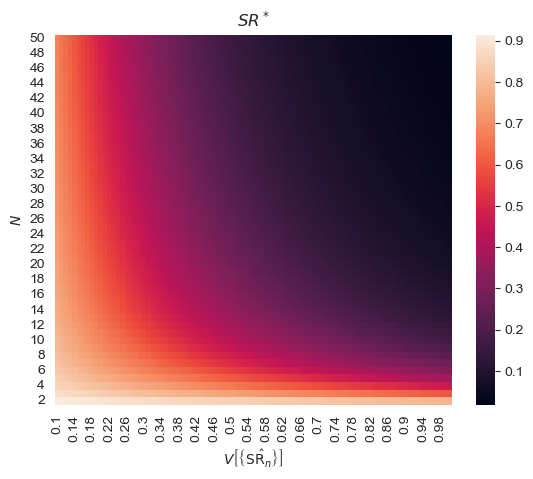

In [10]:
sns.heatmap(dsr)
plt.title(r'$SR^*$')
plt.xlabel(r'$V\left[ \left\{ \hat{\text{SR}_n}\right\}\right]$')
plt.ylabel(r'$N$')
plt.show()